In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define your dataset path from Google Drive (adjust accordingly)
path = "/content/drive/My Drive/Model_path/student_6_6_3072_model_final.pth"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **CoLA**

In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets --upgrade

In [ ]:
!pip uninstall datasets
!pip install datasets

Found existing installation: datasets 3.0.2
Uninstalling datasets-3.0.2:
  Would remove:
    /usr/local/bin/datasets-cli
    /usr/local/lib/python3.10/dist-packages/datasets-3.0.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/datasets/*
Proceed (Y/n)? y
  Successfully uninstalled datasets-3.0.2
  Using cached datasets-3.0.2-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.0.2-py3-none-any.whl (472 kB)


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.5 MB/s eta 0:00:00


# ***CoLA***

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load LastBERT tokenizer and model for classification task (CoLA)
tokenizer = AutoTokenizer.from_pretrained("Peraboom/LastBERT")
model = AutoModelForSequenceClassification.from_pretrained(
    "Peraboom/LastBERT", num_labels=2, ignore_mismatched_sizes=True
).to(device)  # Binary classification (acceptance vs rejection of sentence)

# Load CoLA dataset
dataset = load_dataset("glue", "cola")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define Metrics Calculation
matthews_metric = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = torch.tensor(p.predictions)
    preds = torch.argmax(preds, dim=1)  # Convert logits to predicted classes

    # Compute metrics using sklearn
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)

    # Compute Matthews Correlation
    matthews_corr = matthews_metric.compute(predictions=preds, references=p.label_ids)["matthews_correlation"]

    return {
        "matthews_correlation": matthews_corr,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "matthews_correlation": [],
                        "accuracy": [], "precision": [], "recall": [], "f1": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_matthews_correlation" in logs:
                self.metrics["matthews_correlation"].append(logs["eval_matthews_correlation"])
            if "eval_accuracy" in logs:
                self.metrics["accuracy"].append(logs["eval_accuracy"])
            if "eval_precision" in logs:
                self.metrics["precision"].append(logs["eval_precision"])
            if "eval_recall" in logs:
                self.metrics["recall"].append(logs["eval_recall"])
            if "eval_f1" in logs:
                self.metrics["f1"].append(logs["eval_f1"])

metrics_callback = MetricsCallback()

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=12,
    eval_strategy="epoch",
    logging_dir='./logs_cola',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_cola',
    load_best_model_at_end=True,
    metric_for_best_model="matthews_correlation",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to avoid unnecessary logging
)

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

# Train and Evaluate the Model
trainer.train()



Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Matthews Correlation,Accuracy,Precision,Recall,F1
1,0.610100,0.613775,0.000000,0.691275,0.691275,1.000000,0.817460
2,0.593100,0.629010,0.085606,0.680729,0.703354,0.930652,0.801194
3,0.541800,0.651499,0.060362,0.673058,0.700000,0.922330,0.795931
4,0.501300,0.737318,0.034057,0.660594,0.696677,0.901526,0.785973
5,0.466800,0.702770,0.078060,0.665388,0.705298,0.886269,0.785495
6,0.417700,0.784854,0.111958,0.621285,0.725762,0.726768,0.726265
7,0.401200,0.881772,0.113632,0.638543,0.722222,0.775312,0.747826
8,0.394600,0.947760,0.110636,0.617450,0.726124,0.717060,0.721563
9,0.371900,1.039667,0.122187,0.647172,0.723135,0.793343,0.756614
10,0.341200,1.011428,0.121110,0.650048,0.721945,0.803051,0.760341


TrainOutput(global_step=12828, training_loss=0.4391165627175341, metrics={'train_runtime': 2525.7748, 'train_samples_per_second': 40.626, 'train_steps_per_second': 5.079, 'total_flos': 5637235786113024.0, 'train_loss': 0.4391165627175341, 'epoch': 12.0})

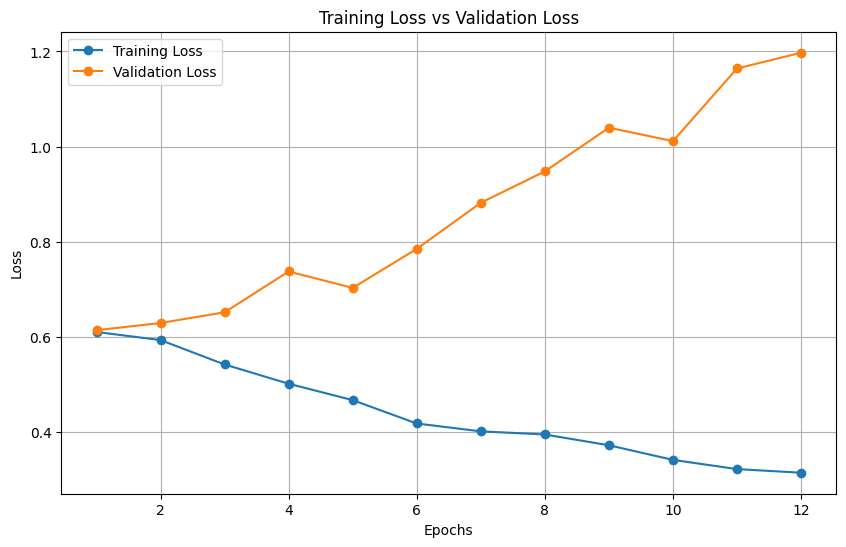

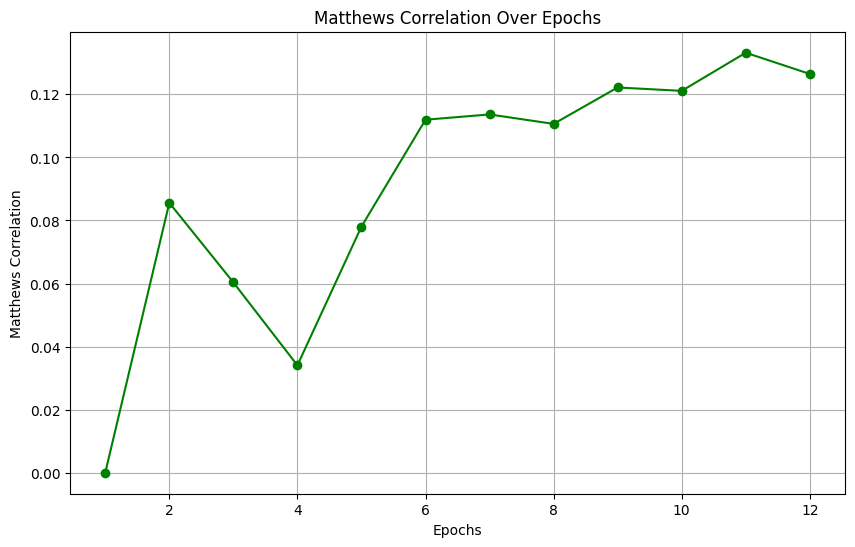

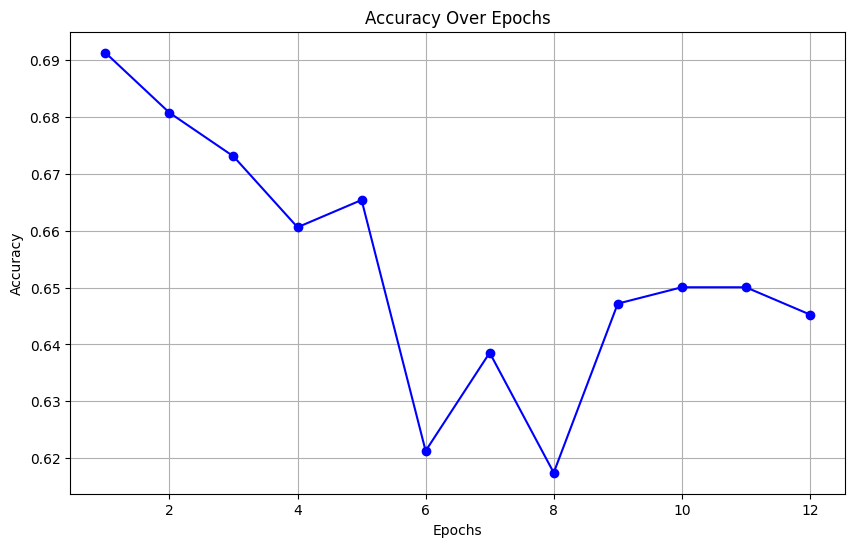

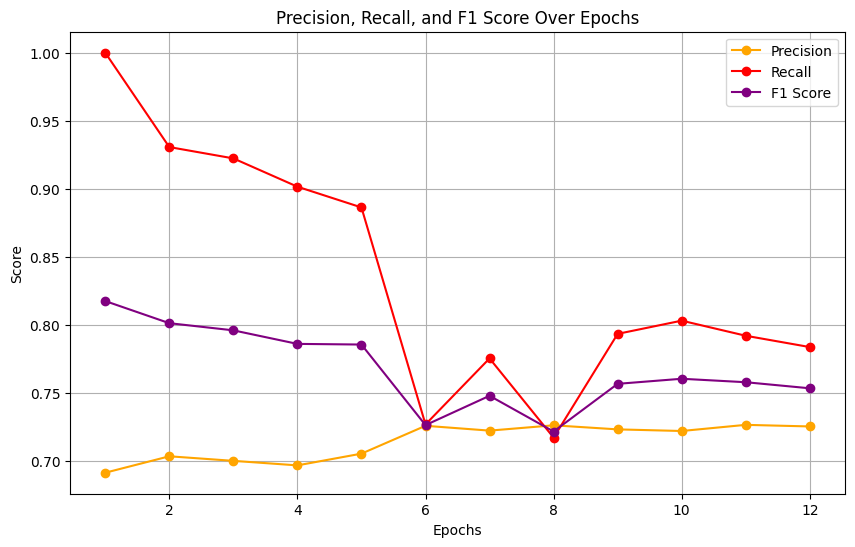

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for 12 epochs
epochs = np.arange(1, 13)
training_loss = [0.610100, 0.593100, 0.541800, 0.501300, 0.466800, 0.417700, 0.401200, 0.394600, 0.371900, 0.341200, 0.321800, 0.314200]
validation_loss = [0.613775, 0.629010, 0.651499, 0.737318, 0.702770, 0.784854, 0.881772, 0.947760, 1.039667, 1.011428, 1.164145, 1.197265]
matthews_correlation = [0.000000, 0.085606, 0.060362, 0.034057, 0.078060, 0.111958, 0.113632, 0.110636, 0.122187, 0.121110, 0.133207, 0.126476]
accuracy = [0.691275, 0.680729, 0.673058, 0.660594, 0.665388, 0.621285, 0.638543, 0.617450, 0.647172, 0.650048, 0.650048, 0.645254]
precision = [0.691275, 0.703354, 0.700000, 0.696677, 0.705298, 0.725762, 0.722222, 0.726124, 0.723135, 0.721945, 0.726463, 0.725289]
recall = [1.000000, 0.930652, 0.922330, 0.901526, 0.886269, 0.726768, 0.775312, 0.717060, 0.793343, 0.803051, 0.791956, 0.783634]
f1 = [0.817460, 0.801194, 0.795931, 0.785973, 0.785495, 0.726265, 0.747826, 0.721563, 0.756614, 0.760341, 0.757797, 0.753333]

# Plot Training Loss vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Matthews Correlation
plt.figure(figsize=(10, 6))
plt.plot(epochs, matthews_correlation, label='Matthews Correlation', marker='o', color='green')
plt.title('Matthews Correlation Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Matthews Correlation')
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Accuracy', marker='o', color='blue')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, label='Precision', marker='o', color='orange')
plt.plot(epochs, recall, label='Recall', marker='o', color='red')
plt.plot(epochs, f1, label='F1 Score', marker='o', color='purple')
plt.title('Precision, Recall, and F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
'''
import matplotlib.pyplot as plt
import numpy as np

# Data for 12 epochs
epochs = np.arange(1, 13)
training_loss = [0.610100, 0.593100, 0.541800, 0.501300, 0.466800, 0.417700, 0.401200, 0.394600, 0.371900, 0.341200, 0.321800, 0.314200]
validation_loss = [0.613775, 0.629010, 0.651499, 0.737318, 0.702770, 0.784854, 0.881772, 0.947760, 1.039667, 1.011428, 1.164145, 1.197265]
matthews_correlation = [0.000000, 0.085606, 0.060362, 0.034057, 0.078060, 0.111958, 0.113632, 0.110636, 0.122187, 0.121110, 0.133207, 0.126476]
accuracy = [0.691275, 0.680729, 0.673058, 0.660594, 0.665388, 0.621285, 0.638543, 0.617450, 0.647172, 0.650048, 0.650048, 0.645254]
precision = [0.691275, 0.703354, 0.700000, 0.696677, 0.705298, 0.725762, 0.722222, 0.726124, 0.723135, 0.721945, 0.726463, 0.725289]
recall = [1.000000, 0.930652, 0.922330, 0.901526, 0.886269, 0.726768, 0.775312, 0.717060, 0.793343, 0.803051, 0.791956, 0.783634]
f1 = [0.817460, 0.801194, 0.795931, 0.785973, 0.785495, 0.726265, 0.747826, 0.721563, 0.756614, 0.760341, 0.757797, 0.753333]

# 1. Bar Plot for Training Loss vs Validation Loss
plt.figure(figsize=(10, 6))
bar_width = 0.35
bar1 = np.arange(len(epochs))
bar2 = [i + bar_width for i in bar1]

plt.bar(bar1, training_loss, color='b', width=bar_width, label='Training Loss')
plt.bar(bar2, validation_loss, color='r', width=bar_width, label='Validation Loss')
plt.title('Training Loss vs Validation Loss (Bar Plot)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([r + bar_width / 2 for r in range(len(epochs))], epochs)
plt.legend()
plt.grid(True, axis='y')
plt.show()

# 2. Scatter Plot for Matthews Correlation
plt.figure(figsize=(10, 6))
plt.scatter(epochs, matthews_correlation, color='green', s=100, marker='x', label='Matthews Correlation')
plt.plot(epochs, matthews_correlation, color='green', linestyle='dashed')
plt.title('Matthews Correlation Over Epochs (Scatter Plot)')
plt.xlabel('Epochs')
plt.ylabel('Matthews Correlation')
plt.grid(True)
plt.legend()
plt.show()

# 3. Step Plot for Accuracy
plt.figure(figsize=(10, 6))
plt.step(epochs, accuracy, label='Accuracy', where='mid', color='blue', linewidth=2)
plt.fill_between(epochs, accuracy, step='mid', alpha=0.4, color='blue')
plt.title('Accuracy Over Epochs (Step Plot)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# 4. Precision, Recall, and F1 with Subplots (Line Plot)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Precision, Recall, and F1 Score Over Epochs (Subplots)')

# Precision
ax1.plot(epochs, precision, marker='o', color='orange')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Recall
ax2.plot(epochs, recall, marker='o', color='red')
ax2.set_ylabel('Recall')
ax2.grid(True)

# F1 Score
ax3.plot(epochs, f1, marker='o', color='purple')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('F1 Score')
ax3.grid(True)

plt.show()
'''


SyntaxError: incomplete input (<ipython-input-12-0ee31eebd46a>, line 1)

# ***Sts-b***

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction, TrainerCallback
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt

In [ ]:

# Load device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load LastBERT tokenizer and model for regression task (STS-B)
tokenizer = AutoTokenizer.from_pretrained("Peraboom/LastBERT")
model = AutoModelForSequenceClassification.from_pretrained(
    "Peraboom/LastBERT", num_labels=1, ignore_mismatched_sizes=True
).to(device)

# Load the STS-B dataset from the GLUE benchmark
dataset = load_dataset("glue", "stsb")

# Tokenization function for the STS-B dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"], padding="max_length", truncation=True)

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Load evaluation metrics using the evaluate library
pearson_metric = evaluate.load("pearsonr")
spearman_metric = evaluate.load("spearmanr")

# Function to compute evaluation metrics (Pearson and Spearman correlations)
def compute_metrics(p: EvalPrediction):
    preds = p.predictions.squeeze()  # For regression tasks
    pearson_corr = pearson_metric.compute(predictions=preds, references=p.label_ids)["pearsonr"]
    spearman_corr = spearman_metric.compute(predictions=preds, references=p.label_ids)["spearmanr"]
    return {"pearson": pearson_corr, "spearman": spearman_corr}

# Callback class to store metrics after each epoch
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "pearson": [], "spearman": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_pearson" in logs:
                self.metrics["pearson"].append(logs["eval_pearson"])
            if "eval_spearman" in logs:
                self.metrics["spearman"].append(logs["eval_spearman"])

metrics_callback = MetricsCallback()

# Define training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=12,
    eval_strategy="epoch",
    logging_dir='./logs_stsb',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_stsb',
    load_best_model_at_end=True,
    metric_for_best_model="pearson",
    save_strategy="epoch",
    report_to="none",
)

# Add the labels (i.e., similarity scores) to the tokenized datasets
tokenized_datasets = tokenized_datasets.map(lambda examples: {'labels': examples['label']}, batched=True)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback],
)

# Train and evaluate the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/119M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Peraboom/LastBERT and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 384]) in the checkpoint and torch.Size([1, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/502k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Pearson,Spearman
1,2.116600,2.958220,0.142264,0.043145
2,1.884400,2.230632,0.298490,0.290694
3,1.397200,2.612316,0.273514,0.285997
4,1.116400,2.531901,0.297106,0.297752
5,0.793900,2.701890,0.293077,0.288342
6,0.645800,2.483943,0.308699,0.312130
7,0.511700,2.968095,0.303079,0.305295
8,0.387000,2.666734,0.310227,0.309605
9,0.394100,2.650522,0.322781,0.323407
10,0.294400,2.702201,0.311790,0.311669


TrainOutput(global_step=8628, training_loss=0.807260595762901, metrics={'train_runtime': 1744.6433, 'train_samples_per_second': 39.543, 'train_steps_per_second': 4.945, 'total_flos': 3789939285282816.0, 'train_loss': 0.807260595762901, 'epoch': 12.0})

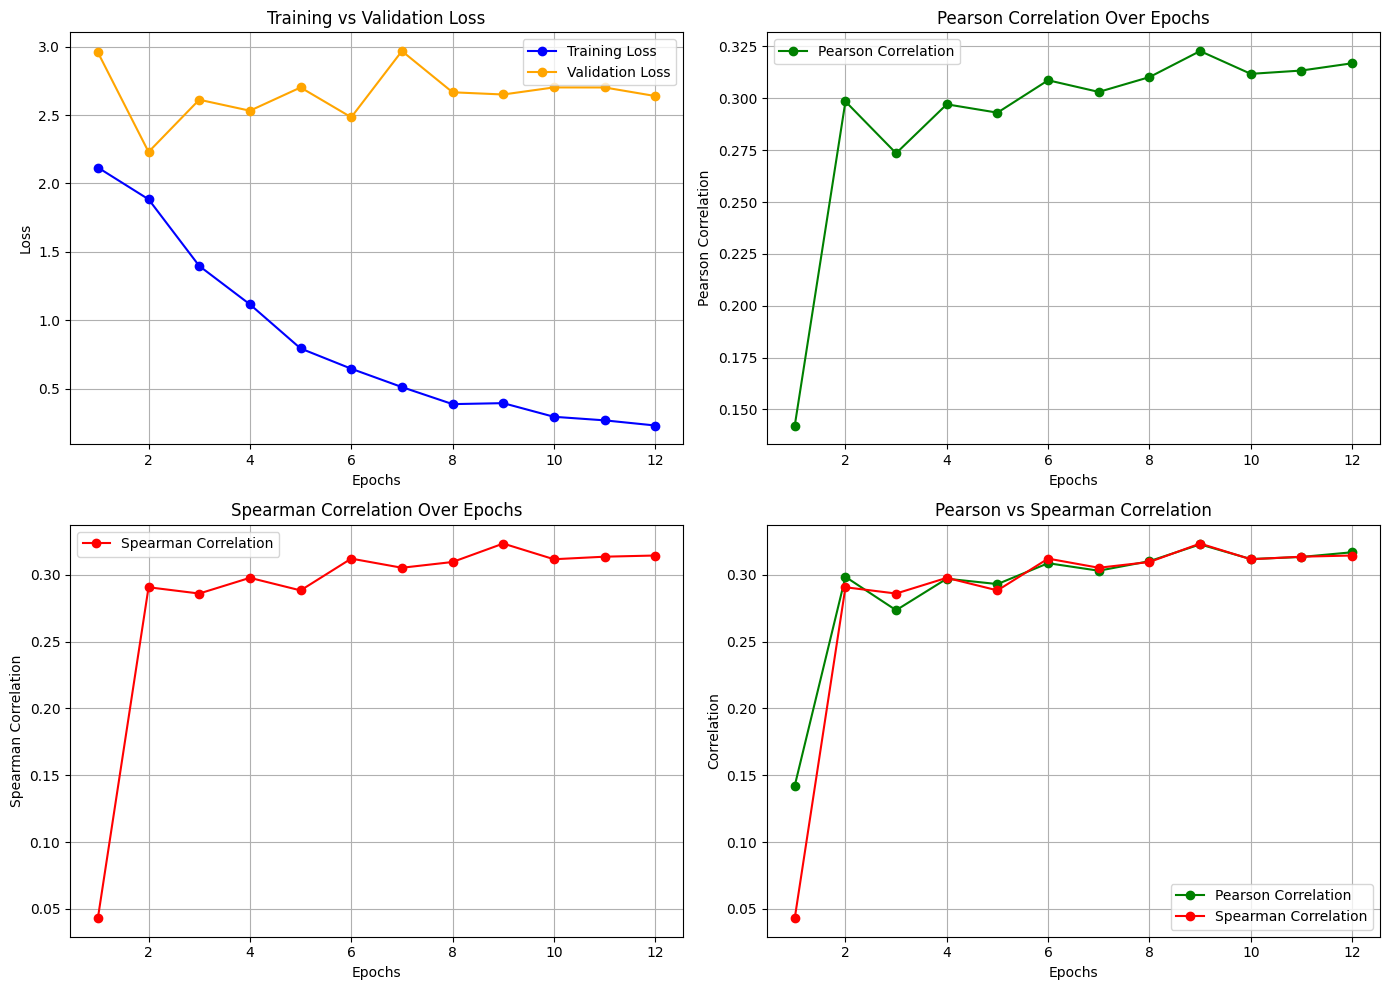

In [1]:
import matplotlib.pyplot as plt

# Data for epochs
epochs = list(range(1, 13))  # 12 epochs

# Data from the table
training_loss = [2.116600, 1.884400, 1.397200, 1.116400, 0.793900, 0.645800, 0.511700, 0.387000, 0.394100, 0.294400, 0.268400, 0.230700]
validation_loss = [2.958220, 2.230632, 2.612316, 2.531901, 2.701890, 2.483943, 2.968095, 2.666734, 2.650522, 2.702201, 2.701942, 2.639239]
pearson_corr = [0.142264, 0.298490, 0.273514, 0.297106, 0.293077, 0.308699, 0.303079, 0.310227, 0.322781, 0.311790, 0.313389, 0.316892]
spearman_corr = [0.043145, 0.290694, 0.285997, 0.297752, 0.288342, 0.312130, 0.305295, 0.309605, 0.323407, 0.311669, 0.313573, 0.314460]

# Create subplots for the graphs
plt.figure(figsize=(14, 10))

# Plot 1: Training vs. Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, training_loss, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Pearson Correlation Over Epochs
plt.subplot(2, 2, 2)
plt.plot(epochs, pearson_corr, label="Pearson Correlation", marker='o', color='green')
plt.title('Pearson Correlation Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Pearson Correlation')
plt.legend()
plt.grid(True)

# Plot 3: Spearman Correlation Over Epochs
plt.subplot(2, 2, 3)
plt.plot(epochs, spearman_corr, label="Spearman Correlation", marker='o', color='red')
plt.title('Spearman Correlation Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Spearman Correlation')
plt.legend()
plt.grid(True)

# Plot 4: Pearson vs Spearman Correlation
plt.subplot(2, 2, 4)
plt.plot(epochs, pearson_corr, label="Pearson Correlation", marker='o', color='green')
plt.plot(epochs, spearman_corr, label="Spearman Correlation", marker='o', color='red')
plt.title('Pearson vs Spearman Correlation')
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
